In [1]:
import os
import json

json_folder = 'GL_v3\Labeled_GL_sample_3'
json_files = [f for f in os.listdir(json_folder) if f.endswith('.json')]

data_list = []
for file_name in json_files:
    file_path = os.path.join(json_folder, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        data_list.append(data)

<>:4: SyntaxWarning: invalid escape sequence '\L'
<>:4: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Sacchi\AppData\Local\Temp\ipykernel_5316\1983208093.py:4: SyntaxWarning: invalid escape sequence '\L'
  json_folder = 'GL_v3\Labeled_GL_sample_3'


chuyển thành bản đẹp


In [2]:
# Beautify all JSON files in the folder
for file_name in json_files:
    file_path = os.path.join(json_folder, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4, sort_keys=True)
print("All JSON files have been beautified.")

All JSON files have been beautified.


Thống kê các annotation và fleiss kappa

In [3]:
# Lập bảng tổng hợp annotator x choice và tính Fleiss' kappa cho từng trường from_name, xuất ra 1 bảng tổng hợp kết quả kappa

import os
import json
import pandas as pd
import numpy as np

def fleiss_kappa(M):
    """
    M: numpy array (n_items, n_categories), mỗi dòng là số annotator chọn mỗi choice cho 1 item
    """
    N, k = M.shape
    n_annotators = np.sum(M[0])
    P = np.sum(M, axis=0) / (N * n_annotators)
    P_i = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    P_bar = np.mean(P_i)
    P_e = np.sum(P * P)
    kappa = (P_bar - P_e) / (1 - P_e) if (1 - P_e) != 0 else np.nan
    return kappa

annotators = ['Cuong', 'Duyet', 'Vuong']
choices_map = {
    'All_helpfulness': ['1', '2', '3'],
    # Các trường khác giữ nguyên 1-5
}
default_choices = ['1', '2', '3', '4', '5']

# Lấy tất cả from_name có trong các file annotator
from_names = set()
for annotator in annotators:
    path = os.path.join(json_folder, f'{annotator}.json')
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        anns = item.get('annotations', [])
        if not anns: continue
        ann = anns[0]
        for r in ann.get('result', []):
            fname = r.get('from_name')
            if fname:
                from_names.add(fname)
from_names = sorted(from_names)

kappa_results = {}
for fname in from_names:
    # Lựa chọn choices phù hợp cho từng trường
    choices = choices_map.get(fname, default_choices)
    # Tạo bảng tổng hợp annotator x choice
    rows = []
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        counts = {c: 0 for c in choices}
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        counts[val[0]] += 1
        row = [counts[c] for c in choices]
        rows.append(row)
    df = pd.DataFrame(rows, columns=[f' {c}' for c in choices], index=annotators)
    df.index.name = 'Annotator'
    print(f'Bảng tổng hợp cho trường: {fname}')
    display(df)

    # Tạo ma trận Fleiss: mỗi dòng là 1 item, mỗi cột là số annotator chọn choice đó
    rows2 = []
    n_items = None
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        item_choices = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            found = False
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        item_choices.append(val[0])
                        found = True
                        break
            if not found:
                item_choices.append(None)
        rows2.append(item_choices)
        if n_items is None:
            n_items = len(item_choices)
    M = np.zeros((n_items, len(choices)), dtype=int)
    for i in range(n_items):
        for j, annotator in enumerate(annotators):
            v = rows2[j][i]
            if v is not None:
                idx = choices.index(v)
                M[i, idx] += 1
    kappa = fleiss_kappa(M)
    kappa_results[fname] = kappa
    print(f"Fleiss' kappa cho trường {fname}: {kappa:.4f}")

# Xuất bảng tổng hợp Fleiss' kappa
kappa_df = pd.DataFrame.from_dict(kappa_results, orient='index', columns=['Fleiss\' kappa'])
display(kappa_df)

Bảng tổng hợp cho trường: All_helpfulness


,1,2,3
Annotator,,,
Cuong,14,8,48
Duyet,17,24,29
Vuong,12,30,28


Fleiss' kappa cho trường All_helpfulness: 0.5935
Bảng tổng hợp cho trường: Comment_helpfulness


,1,2,3,4,5
Annotator,,,,,
Cuong,4,11,16,19,20
Duyet,4,17,18,21,10
Vuong,4,11,7,39,9


Fleiss' kappa cho trường Comment_helpfulness: 0.5608
Bảng tổng hợp cho trường: Image_helpfulness


,1,2,3,4,5
Annotator,,,,,
Cuong,36,5,5,9,15
Duyet,30,10,15,1,13
Vuong,30,10,20,1,8


Fleiss' kappa cho trường Image_helpfulness: 0.6437


,Fleiss' kappa
All_helpfulness,0.593529
Comment_helpfulness,0.560803
Image_helpfulness,0.643749


# EDA: Phân tích nguyên nhân độ đồng thuận thấp giữa các annotator

Phân tích phân phối lựa chọn của từng annotator, kiểm tra sự khác biệt giữa các annotator, và tìm các trường hợp bất đồng mạnh.

--- Phân tích trường: All_helpfulness ---


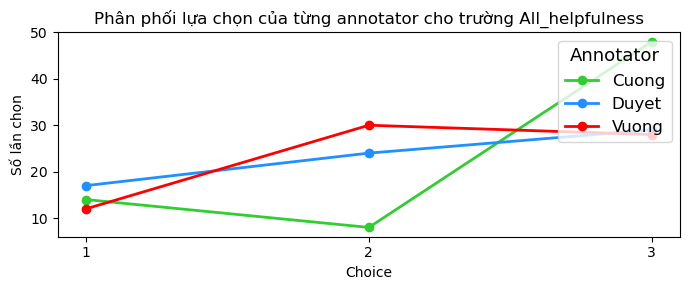

Số item bất đồng hoàn toàn (1/70): [39]
Tỉ lệ trùng giữa Cuong và Duyet: 47/70 = 67.14%
Tỉ lệ trùng giữa Cuong và Vuong: 48/70 = 68.57%
Tỉ lệ trùng giữa Duyet và Vuong: 62/70 = 88.57%

--- Phân tích trường: Comment_helpfulness ---


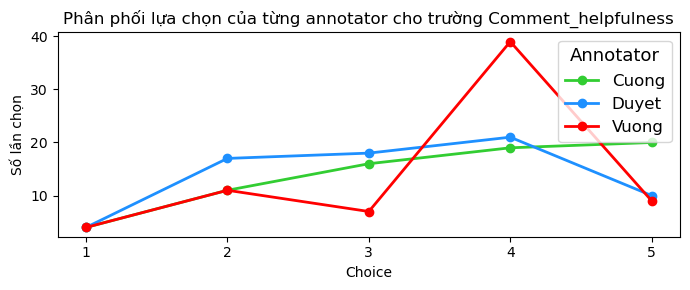

Số item bất đồng hoàn toàn (3/70): [14, 23, 25]
Tỉ lệ trùng giữa Cuong và Duyet: 50/70 = 71.43%
Tỉ lệ trùng giữa Cuong và Vuong: 46/70 = 65.71%
Tỉ lệ trùng giữa Duyet và Vuong: 45/70 = 64.29%

--- Phân tích trường: Image_helpfulness ---


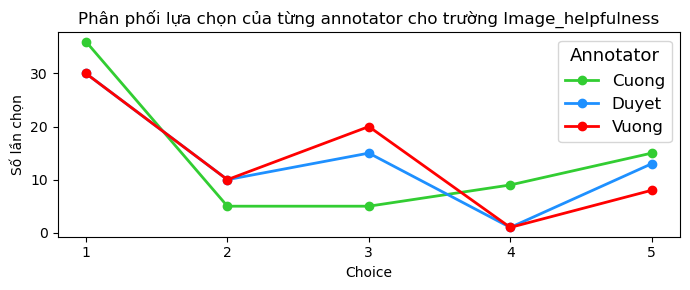

Số item bất đồng hoàn toàn (2/70): [19, 41]
Tỉ lệ trùng giữa Cuong và Duyet: 51/69 = 73.91%
Tỉ lệ trùng giữa Cuong và Vuong: 49/69 = 71.01%
Tỉ lệ trùng giữa Duyet và Vuong: 58/68 = 85.29%



In [4]:
# EDA: Phân tích chi tiết về sự khác biệt giữa các annotator cho từng trường from_name

import matplotlib.pyplot as plt
import seaborn as sns

for fname in from_names:
    print(f"--- Phân tích trường: {fname} ---")
    # 1. Phân phối lựa chọn của từng annotator
    # Lựa chọn choices phù hợp cho từng trường
    choices = choices_map.get(fname, default_choices)
    fig, ax = plt.subplots(figsize=(7, 3))
    dist = []
    color_map = {'Cuong': 'limegreen', 'Duyet': 'dodgerblue', 'Vuong': 'red'}
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        choices_list = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        choices_list.append(val[0])
        counts = pd.Series(choices_list).value_counts().reindex(choices, fill_value=0)
        dist.append(counts)
        ax.plot(counts.index, counts.values, marker='o', label=annotator, color=color_map.get(annotator, None), linewidth=2)
    plt.title(f'Phân phối lựa chọn của từng annotator cho trường {fname}')
    plt.xlabel('Choice')
    plt.ylabel('Số lần chọn')
    plt.legend(annotators, fontsize=12, title="Annotator", title_fontsize=13, loc='upper right')
    plt.tight_layout()
    plt.show()

    # 2. Phân tích các item có bất đồng mạnh (tức là các annotator chọn khác nhau hoàn toàn)
    # Tạo ma trận annotator x item (giá trị choice)
    rows2 = []
    n_items = None
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        item_choices = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            found = False
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        item_choices.append(val[0])
                        found = True
                        break
            if not found:
                item_choices.append(None)
        rows2.append(item_choices)
        if n_items is None:
            n_items = len(item_choices)
    # Tìm các item mà tất cả annotator đều chọn khác nhau (không trùng)
    disagreement_items = []
    for i in range(n_items):
        vals = [rows2[j][i] for j in range(len(annotators)) if rows2[j][i] is not None]
        if len(set(vals)) == len(vals) and len(vals) == len(annotators):
            disagreement_items.append(i)
    print(f"Số item bất đồng hoàn toàn ({len(disagreement_items)}/{n_items}): {disagreement_items[:10]}{'...' if len(disagreement_items)>10 else ''}")

    # 3. Phân tích các cặp annotator: tỉ lệ trùng lặp lựa chọn
    for i in range(len(annotators)):
        for j in range(i+1, len(annotators)):
            agree = 0
            total = 0
            for k in range(n_items):
                v1 = rows2[i][k]
                v2 = rows2[j][k]
                if v1 is not None and v2 is not None:
                    total += 1
                    if v1 == v2:
                        agree += 1
            print(f"Tỉ lệ trùng giữa {annotators[i]} và {annotators[j]}: {agree}/{total} = {agree/total:.2%}" if total else f"{annotators[i]} vs {annotators[j]}: không đủ dữ liệu")
    print()

## Phân tích chi tiết: Vì sao tỉ lệ đồng thuận giữa Cuong và các annotator còn lại thấp?

Ta sẽ vẽ thêm các biểu đồ so sánh trực tiếp giữa Cuong với Duyet và Cuong với Vuong, bao gồm:
- Ma trận confusion (so sánh từng lựa chọn giữa hai annotator)
- Biểu đồ phân phối chênh lệch lựa chọn giữa hai annotator
- Thống kê các trường hợp bất đồng lớn nhất

--- So sánh chi tiết giữa Cuong và các annotator cho trường: All_helpfulness ---

Biểu đồ confusion giữa Cuong và Duyet:


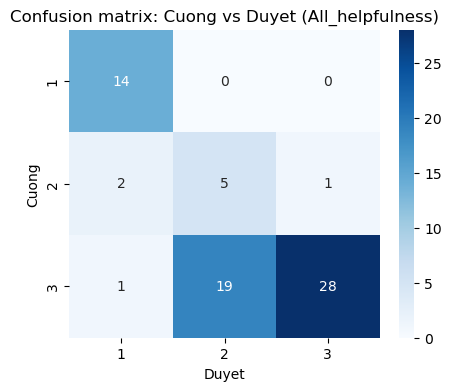

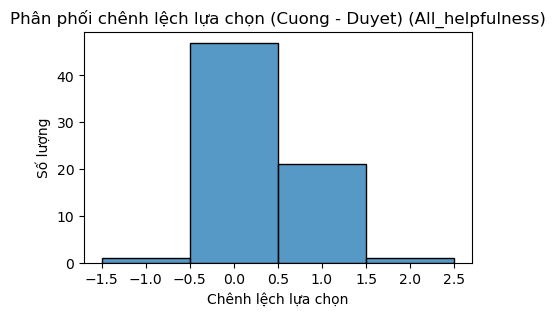

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 1
Vị trí các item bất đồng lớn nhất: [39] 

Biểu đồ confusion giữa Cuong và Vuong:


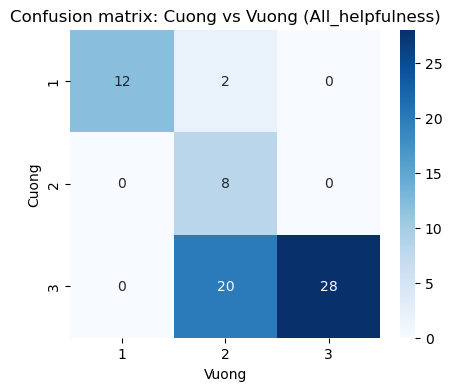

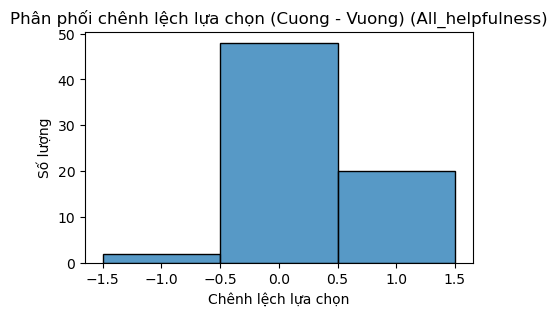

Số trường hợp bất đồng lớn nhất (|chênh lệch|=1): 22
Vị trí các item bất đồng lớn nhất: [ 0  2  3  5  7  9 16 18 22 33] ...

--- So sánh chi tiết giữa Cuong và các annotator cho trường: Comment_helpfulness ---

Biểu đồ confusion giữa Cuong và Duyet:


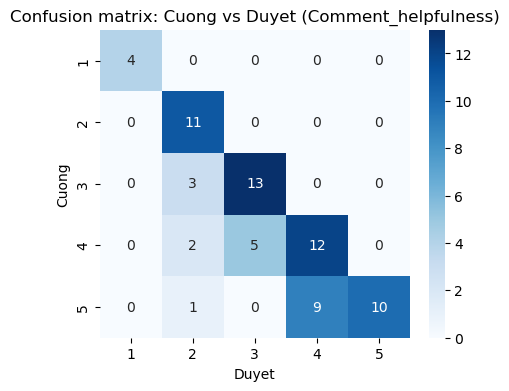

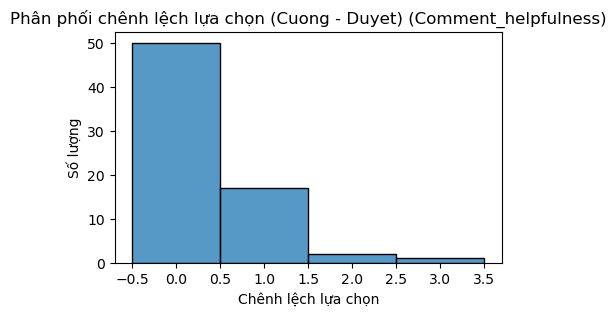

Số trường hợp bất đồng lớn nhất (|chênh lệch|=3): 1
Vị trí các item bất đồng lớn nhất: [25] 

Biểu đồ confusion giữa Cuong và Vuong:


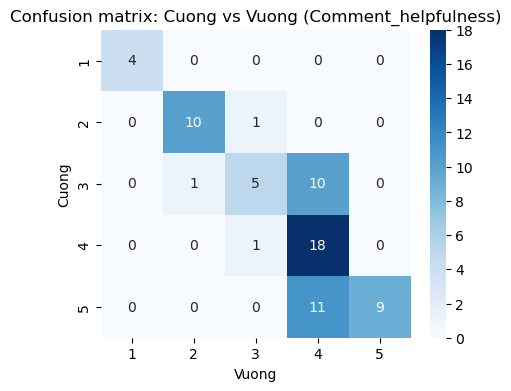

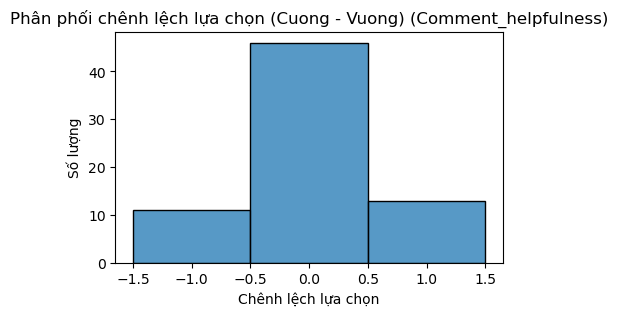

Số trường hợp bất đồng lớn nhất (|chênh lệch|=1): 24
Vị trí các item bất đồng lớn nhất: [ 1  3  5 10 11 14 17 23 25 28] ...

--- So sánh chi tiết giữa Cuong và các annotator cho trường: Image_helpfulness ---

Biểu đồ confusion giữa Cuong và Duyet:


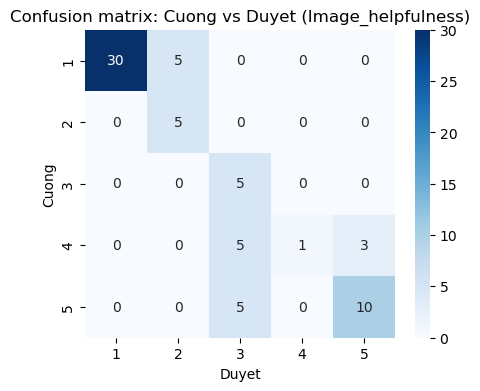

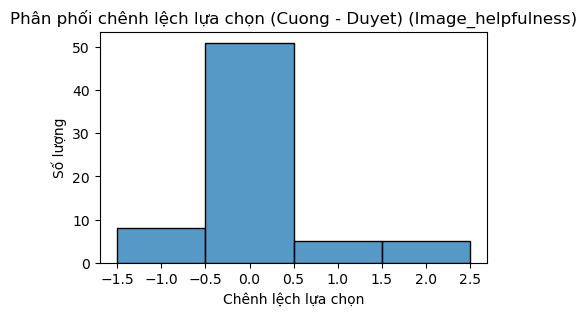

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 5
Vị trí các item bất đồng lớn nhất: [14 28 31 51 59] 

Biểu đồ confusion giữa Cuong và Vuong:


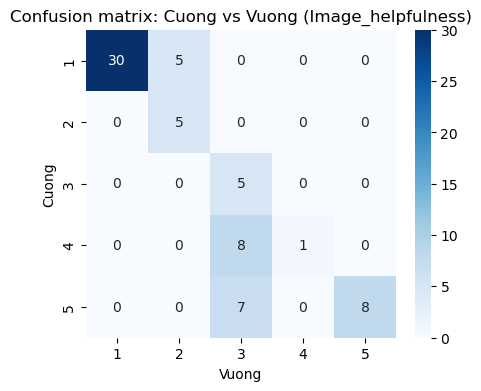

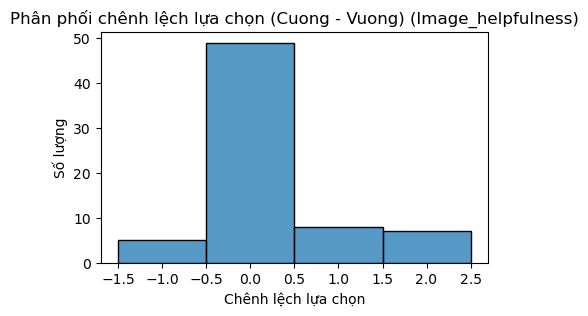

Số trường hợp bất đồng lớn nhất (|chênh lệch|=2): 7
Vị trí các item bất đồng lớn nhất: [11 20 27 28 29 30 59] 



In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

for fname in from_names:
    print(f"--- So sánh chi tiết giữa Cuong và các annotator cho trường: {fname} ---")
    choices = choices_map.get(fname, default_choices)
    # Lấy lựa chọn của từng annotator cho từng item
    annotator_choices = {}
    for annotator in annotators:
        path = os.path.join(json_folder, f'{annotator}.json')
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        item_choices = []
        for item in data:
            anns = item.get('annotations', [])
            if not anns: continue
            ann = anns[0]
            found = False
            for r in ann.get('result', []):
                if r.get('from_name') == fname:
                    val = r.get('value', {}).get('choices', [])
                    if val and val[0] in choices:
                        item_choices.append(val[0])
                        found = True
                        break
            if not found:
                item_choices.append(None)
        annotator_choices[annotator] = item_choices

    # So sánh Cuong với Duyet và Cuong với Vuong
    for other in ['Duyet', 'Vuong']:
        c1 = np.array(annotator_choices['Cuong'])
        c2 = np.array(annotator_choices[other])
        mask = (c1 != None) & (c2 != None)
        c1_valid = c1[mask]
        c2_valid = c2[mask]
        print(f"\nBiểu đồ confusion giữa Cuong và {other}:")
        cm = pd.crosstab(c1_valid, c2_valid, rownames=['Cuong'], colnames=[other], dropna=False)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix: Cuong vs {other} ({fname})')
        plt.show()

        # Biểu đồ phân phối chênh lệch lựa chọn
        diff = c1_valid.astype(int) - c2_valid.astype(int)
        plt.figure(figsize=(5,3))
        sns.histplot(diff, bins=np.arange(diff.min()-0.5, diff.max()+1.5), kde=False)
        plt.title(f'Phân phối chênh lệch lựa chọn (Cuong - {other}) ({fname})')
        plt.xlabel('Chênh lệch lựa chọn')
        plt.ylabel('Số lượng')
        plt.show()

        # Thống kê các trường hợp bất đồng lớn nhất
        abs_diff = np.abs(diff)
        max_diff = abs_diff.max() if len(abs_diff) > 0 else 0
        idxs = np.where(abs_diff == max_diff)[0]
        print(f"Số trường hợp bất đồng lớn nhất (|chênh lệch|={max_diff}): {len(idxs)}")
        if len(idxs) > 0:
            print("Vị trí các item bất đồng lớn nhất:", idxs[:10], "..." if len(idxs) > 10 else "")
    print()